## Chapter 3

### Gridworld

In [1]:
from time import sleep
from numpy import zeros_like
from copy import deepcopy

import util as c3
from gridworld import SS, GAgent, Gridworld

from mdp.unit import Strategy, SelectA
from mdp.learning import V
from mdp.framework import Policy

In [2]:
special_states = [
    SS('A ', (0, 1), (4, 1), 10),
    SS('B ', (0, 3), (2, 3), 5)
]

policy = Policy(
    name="random", strategy=Strategy.off, select=SelectA.rand, v=V(θ=1e-3, γ=0.9)
)
agent = GAgent(Gridworld(init=(0, 3), specials=special_states), π=policy)
print(agent.env)

[[_  A  _  B  _ ]
 [_  _  _  _  _ ]
 [_  _  _  B' _ ]
 [_  _  _  _  _ ]
 [_  A' _  _  _ ]]


In [3]:
# let the agent wonder for a bit to see how it behaves
c3.walk(agent, steps=10, pause=0.5)

'o' = current state, '+' = candidate states
 step: 9\10

 4.0 <- reward=0.0 
[[_  A  _  +  o ]
 [_  _  _  _  + ]
 [_  _  _  B' _ ]
 [_  _  _  _  _ ]
 [_  A' _  _  _ ]]
T(t=8, s=_ , a=^, r=-1, rn=0.0) 



### Example 3.5, Page 60

In [4]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [5]:
policy = Policy(name="random", strategy=Strategy.off, select=SelectA.rand, v=V(θ=1e-3, γ=0.9))
agent = GAgent(Gridworld(init=(0, 3), specials=special_states), π=policy)
c3.value_iteration(agent=agent, states=flatten(agent.env.grid))
print('Figure 3.2:')
c3.visualize_values(agent)

Policy(name='random', strategy=off-policy, v=V(t=30, θ=0.0010000, Δ=0.0009068), require_stable=False, converged=True, changes=0, stable=50)
Figure 3.2:
[[ 3.3  8.8  4.4  5.3  1.5]
 [ 1.5  3.0  2.3  1.9  0.6]
 [ 0.1  0.7  0.7  0.4 -0.4]
 [-1.0 -0.4 -0.4 -0.6 -1.2]
 [-1.9 -1.3 -1.2 -1.4 -2.0]]


### Example 3.8, Page 65

In [6]:
policy = Policy(name="optimal", strategy=Strategy.off, select=SelectA.best, v=V(θ=1e-3, γ=0.9))
agent = GAgent(Gridworld(init=(0, 3), specials=special_states), π=policy)
c3.value_iteration(agent=agent, states=flatten(agent.env.grid))
print('Figure 3.5:')
c3.visualize_values(agent)

Policy(name='optimal', strategy=off-policy, v=V(t=20, θ=0.0010000, Δ=0.0006856), require_stable=False, converged=True, changes=0, stable=34)
Figure 3.5:
[[22.0 24.4 22.0 19.4 17.5]
 [19.8 22.0 19.8 17.8 16.0]
 [17.8 19.8 17.8 16.0 14.4]
 [16.0 17.8 16.0 14.4 13.0]
 [14.4 16.0 14.4 13.0 11.7]]


In [7]:
# render the optimal moves per cell
print('Figure 3.5')
c3.visualize_optimal_moves(agent)

Figure 3.5
[[' >  ' '<^v>' ' <  ' '<^v>' ' <  ']
 [' >  ' ' ^  ' ' <^ ' ' <  ' ' <  ']
 [' >  ' ' ^  ' ' <^ ' ' <^ ' ' <^ ']
 [' >  ' ' ^  ' ' <^ ' ' <^ ' ' <^ ']
 [' >  ' ' ^  ' ' <^ ' ' <^ ' ' <^ ']]


### Agent uses optimal policy

Now that we have learned optimal movements from the value function, use this in a new optimal policy and redo the visualization from the top of the notebook.

In [8]:
agent.reset()
agent.π.strategy = Strategy.on
c3.walk(agent, steps=20, pause=0.5)

'o' = current state, '+' = candidate states
 step: 19\20

 35.0 <- reward=0.0 
[[_  +  _  B  _ ]
 [+  o  +  _  _ ]
 [_  +  _  B' _ ]
 [_  _  _  _  _ ]
 [_  A' _  _  _ ]]
T(t=18, s=_ , a=^, r=0.0, rn=0.0) 



### Comparing the random and optimal policies

In [9]:
from random import randint, random
from tqdm import tqdm
import numpy as np
import seaborn as sns
import pandas as pd

random_coordinate = lambda s: (randint(0, s - 1), randint(0, s - 1))
new_agent = lambda s, c, rs, vmb, p: GAgent(Gridworld(init=c, specials=rs, size=s), vmb=vmb, π=p)

def copy_values(a, b):
    a.values, a.optimal_moves = deepcopy(b.values), deepcopy(b.optimal_moves)
    return a

def random_specials(size, max_number = 3):
    names = ['A', 'B', 'C', 'D', 'E']
    max_number = min(max_number, len(names))
    n = randint(1, max_number) # number of special states
    unique = False
    while not unique:
        beg = [random_coordinate(size) for _ in range(n)]
        end = [random_coordinate(size) for _ in range(n)]
        unique = len(set(beg + end)) == n * 2
    bonus = [randint(1, 10) for _ in range(n)]
    return [SS(names[i], beg[i], end[i], bonus[i]) for i in range(n)]

def where(df, func):
    return df[func(df)]

pd.DataFrame.where = where

In [22]:
num_agents, steps = 1000, 200
random_rewards, value_rewards, optimal_rewards = (np.zeros([num_agents, steps]) for _ in range(3))
random_rewards_t, value_rewards_t, optimal_rewards_t = (np.zeros([num_agents, steps]) for _ in range(3))

# make many agents and have them learn values for random grids
for agent in tqdm(range(num_agents)):
    size = randint(5, 9)
    coord = random_coordinate(size)
    rs = random_specials(size)
    valid_move_bonus = round(0.2 * random() + 0.01, 2)
    policies = [
        Policy(name="none", strategy=Strategy.off, select=SelectA.rand, v=V(θ=1e-3, γ=0.9)),
        Policy(name="random", strategy=Strategy.off, select=SelectA.rand, v=V(θ=1e-3, γ=0.9)),
        Policy(name="optimal", strategy=Strategy.off, select=SelectA.best, v=V(θ=1e-3, γ=0.9)),
    ]
    random_agent, value_agent, optimal_agent = (new_agent(size, coord, rs, valid_move_bonus, p) for p in policies)
    
    # learn value functions
    c3.value_iteration(value_agent, states=flatten(value_agent.env.grid), verbose=False)
    c3.value_iteration(optimal_agent, states=flatten(optimal_agent.env.grid), verbose=False)
    value_agent.reset(deep=False)
    optimal_agent.reset(deep=False)

    # switch to target policy
    random_agent.π.strategy = Strategy.off
    value_agent.π.strategy = Strategy.on
    optimal_agent.π.strategy = Strategy.on

    for t in range(steps):
        random_agent.act()
        random_rewards[agent, t] = random_agent.Σr
        random_rewards_t[agent, t] = random_agent.r
        
        value_agent.act()
        value_rewards[agent, t] = value_agent.Σr
        value_rewards_t[agent, t] = value_agent.r

        optimal_agent.act()
        optimal_rewards[agent, t] = optimal_agent.Σr
        optimal_rewards_t[agent, t] = optimal_agent.r

delta_rewards = optimal_rewards - value_rewards
rewards = [random_rewards_t, value_rewards_t, optimal_rewards_t]
cumulative_rewards = [random_rewards, value_rewards, optimal_rewards]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:27<00:00,  5.46it/s]


In [23]:
# Look at a random example from the batch training
a = optimal_agent
a.reset()
print(a.env.first_s.yx)
print(a.env, '\n')
c3.visualize_values(a)
print()
c3.visualize_optimal_moves(a)

(7, 2)
[[_  _  _  _  _  _  _  _  _ ]
 [_  _  _  _  _  _  _  _  _ ]
 [_  _  _  _  _  _  _  _  _ ]
 [_  B  _  _  _  _  _  _  _ ]
 [_  _  _  _  _  _  B' _  _ ]
 [_  _  _  _  _  A  _  _  _ ]
 [_  _  _  _  _  _  A' _  _ ]
 [_  _  _  _  _  _  _  _  _ ]
 [_  _  _  _  _  _  _  _  _ ]] 

[[13.2 14.4 13.2 12.0 11.1 10.2  9.4  8.6  8.0]
 [14.4 15.7 14.4 13.2 12.0 11.1 10.2  9.4  8.6]
 [15.7 17.3 15.7 14.4 13.2 12.0 11.1 10.2  9.4]
 [17.3 18.9 17.3 15.7 14.4 13.2 12.0 11.1 10.2]
 [15.7 17.3 15.7 14.4 13.2 12.0 11.1 10.2  9.4]
 [14.4 15.7 14.4 13.2 12.0 12.4 11.4 10.4  9.6]
 [13.2 14.4 13.2 12.0 11.1 11.4 10.4  9.6  8.9]
 [12.0 13.2 12.0 11.1 10.2 10.4  9.6  8.9  8.2]
 [11.1 12.0 11.1 10.2  9.4  9.6  8.9  8.2  7.6]]

[[' v> ' ' v  ' ' v  ' ' v  ' ' v  ' ' v  ' ' v  ' ' v  ' ' v  ']
 [' v> ' ' v  ' ' v  ' ' v  ' ' v  ' ' v  ' ' v  ' ' v  ' ' v  ']
 [' v> ' ' v  ' ' v  ' ' v  ' ' v  ' ' v  ' ' v  ' ' v  ' ' v  ']
 [' >  ' '<^v>' ' <  ' ' <  ' ' <  ' ' <  ' ' <  ' ' <  ' ' <  ']
 [' >  ' ' ^  ' ' <^ '

In [24]:
a.reset()
c3.walk(a, steps=20, pause=0.5)

'o' = current state, '+' = candidate states
 step: 19\20

 21.6 <- reward=0.21 (Special State)
[[_  _  _  _  _  _  _  _  _ ]
 [_  _  _  _  _  _  _  _  _ ]
 [_  _  _  _  _  _  _  _  _ ]
 [_  o  _  _  _  _  _  _  _ ]
 [_  _  _  _  _  _  +  _  _ ]
 [_  _  _  _  _  A  _  _  _ ]
 [_  _  _  _  _  _  A' _  _ ]
 [_  _  _  _  _  _  _  _  _ ]
 [_  _  _  _  _  _  _  _  _ ]]
T(t=18, s=_ , a=<, r=0.21, rn=0.21) 



### Plot results comparing the rewards of the random, value, and optimal agents

In [25]:
unwrap = lambda t: np.array([
    np.hstack(t).tolist(),
    flatten([[i for i in range(steps)] for j in range(num_agents)]),
    flatten([[j for i in range(steps)] for j in range(num_agents)])
]).T

In [26]:
r_cols, cr_cols = ['reward', 'step', 'agent_count'], ['cumulative_reward', 'step', 'agent_count']
agents = ('random', 'value', 'optimal', 'optimal vs. value')
r_dfs = [pd.DataFrame(data=unwrap(r), columns=r_cols) for r in rewards]
cr_dfs = [pd.DataFrame(data=unwrap(r), columns=cr_cols) for r in cumulative_rewards]
delta_df = pd.DataFrame(data=unwrap(delta_rewards), columns=cr_cols)

r_dfs[0]['agent'], r_dfs[1]['agent'], r_dfs[2]['agent'], delta_df['agent'] = agents
cr_dfs[0]['agent'], cr_dfs[1]['agent'], cr_dfs[2]['agent'] = agents[:3]
df = pd.concat(r_dfs + cr_dfs + [delta_df], sort=True, axis=0)

In [27]:
avg_cum_df = df[['cumulative_reward', 'step', 'agent']].groupby(['agent', 'step']).mean().reset_index()

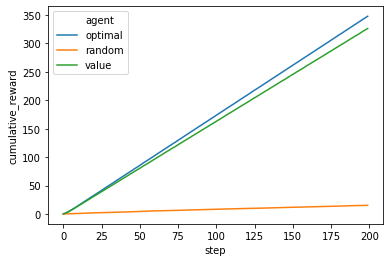

In [28]:
ax = sns.lineplot(
    x='step', y='cumulative_reward', hue='agent',
    data=avg_cum_df.where(lambda x: x['agent'] != 'optimal vs. value')
)

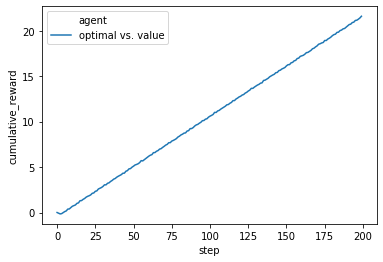

In [29]:
ax = sns.lineplot(
    x='step', y='cumulative_reward', hue='agent',
    data=avg_cum_df.where(lambda x: x['agent'] == 'optimal vs. value')
)

In [30]:
per_agent_df = df[['cumulative_reward', 'agent_count', 'agent']].groupby(['agent', 'agent_count']).mean().reset_index()

Optimal agent


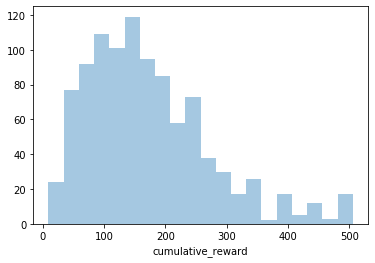

In [31]:
print('Optimal agent')
ax = sns.distplot(
    per_agent_df \
        .where(lambda x: x['agent'] == 'optimal') \
        .where(lambda x: pd.notnull(x['cumulative_reward']))['cumulative_reward'],
    kde=False
)

Random agent


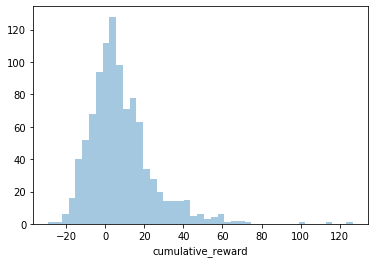

In [32]:
print('Random agent')
ax = sns.distplot(
    per_agent_df \
        .where(lambda x: x['agent'] == 'random') \
        .where(lambda x: pd.notnull(x['cumulative_reward']))['cumulative_reward'],
    kde=False
)